In [ ]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from tabulate import tabulate

  Using cached https://github.com/explosion/spacy-models/releases/download/en_core_web_md-3.8.0/en_core_web_md-3.8.0-py3-none-any.whl (33.5 MB)
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')



[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: C:\Users\bajor\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [6]:
# Download necessary resources
nltk.download('stopwords')
nltk.download('wordnet')
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Load dataset
df = pd.read_csv("sentimentdataset.csv")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\bajor\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\bajor\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [7]:
def preprocess_text(text):
    text = str(text).lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = ' '.join([lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words])  # Lemmatization and removing stopwords
    return text

# Clean up dataframe and preprocess text
df = df[["Text", "Sentiment"]]
df = df.dropna()
df["Sentiment"] = df["Sentiment"].str.strip()
df["ProcessedText"] = df["Text"].apply(preprocess_text)

# Print initial class distribution
print(f"Original number of samples: {len(df)}")
print(f"Original number of unique sentiments: {df['Sentiment'].nunique()}")

Original number of samples: 732
Original number of unique sentiments: 191


In [8]:
# Encode labels
label_encoder = LabelEncoder()
df["SentimentEncoded"] = label_encoder.fit_transform(df["Sentiment"])

In [9]:
# Encode labels and print distribution
label_encoder = LabelEncoder()
df["SentimentEncoded"] = label_encoder.fit_transform(df["Sentiment"])
class_counts = df["SentimentEncoded"].value_counts()
print(f"Class distribution before filtering (top 10): \n{class_counts.head(10)}")

Class distribution before filtering (top 10): 
SentimentEncoded
146    45
116    44
76     37
40     19
135    18
90     18
46     16
166    15
93     14
136    11
Name: count, dtype: int64


In [10]:
# Remove very rare classes (with only 1 sample)
rare_classes = class_counts[class_counts < 2].index
print(f"Number of classes with only 1 sample (to be removed): {len(rare_classes)}")
df = df[~df["SentimentEncoded"].isin(rare_classes)]

Number of classes with only 1 sample (to be removed): 79


In [12]:
# Re-encode labels after filtering to get consecutive class indices
X = df["ProcessedText"]
y_classes = df["Sentiment"]
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y_classes)

print(f"Number of samples after filtering: {len(df)}")
print(f"Number of unique sentiments after filtering: {len(np.unique(y))}")
print(f"Class distribution after filtering (sample counts): {np.bincount(y)[:10]}...")

Number of samples after filtering: 653
Number of unique sentiments after filtering: 112
Class distribution after filtering (sample counts): [8 3 4 2 3 2 6 3 2 3]...


In [13]:
# Split dataset into test and train 
X_train, X_test, y_train, y_test, classes_train, classes_test = train_test_split(
    X, y, y_classes, test_size=0.2, random_state=42, stratify=y
)

print(f"Train set shape: {X_train.shape[0]} samples")
print(f"Test set shape: {X_test.shape[0]} samples")

Train set shape: 522 samples
Test set shape: 131 samples


In [14]:
# Convert text to numerical features
vectorizer = TfidfVectorizer(ngram_range=(1,2), max_features=30000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

print(f"TF-IDF features shape: {X_train_tfidf.shape}")

TF-IDF features shape: (522, 5083)


In [15]:
# Apply SMOTE ONLY to the training data to reduce the class imbalance
class_counts_train = np.bincount(y_train)
print(f"Training set class distribution before SMOTE (min: {min(class_counts_train)}, max: {max(class_counts_train)})")

try:
    smote = SMOTE(random_state=42, k_neighbors=1, sampling_strategy='not majority')
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train_tfidf, y_train)
    print("SMOTE successfully applied")
    print(f"Training samples after SMOTE: {X_train_resampled.shape[0]}")
    unique, counts = np.unique(y_train_resampled, return_counts=True)
    print(f"Class distribution after SMOTE (min: {min(counts)}, max: {max(counts)})")

except Exception as e:
    print(f"Error applying SMOTE: {e}")
    print("Continuing without SMOTE")
    X_train_resampled, y_train_resampled = X_train_tfidf, y_train

# Convert sparse matrix to dense format before accessing samples
X_train_resampled_duplicate = X_train_resampled.copy()
if hasattr(X_train_resampled_duplicate, "toarray"):
    X_train_resampled_duplicate = X_train_resampled_duplicate.toarray()

# sentences after SMOTE
print("\nSample generated training sentences after SMOTE:")
samples = []
for i in range(5):
    original_index = np.random.randint(0, X_train_resampled_duplicate.shape[0])
    sample_vector = X_train_resampled_duplicate[original_index].reshape(1, -1)
    reconstructed_text = vectorizer.inverse_transform(sample_vector)
    sentence = ' '.join(reconstructed_text[0])
    label_encoded = y_train_resampled[original_index]
    label_value = label_encoder.inverse_transform([label_encoded])[0]
    
    samples.append([i + 1, sentence, label_value])

df_samples = pd.DataFrame(samples, columns=["Sample #", "Generated Sentence", "Label"])
display(df_samples) 

Training set class distribution before SMOTE (min: 2, max: 36)
SMOTE successfully applied
Training samples after SMOTE: 4032
Class distribution after SMOTE (min: 36, max: 36)

Sample generated training sentences after SMOTE:


,Sample #,Generated Sentence,Label
0,1,annoyance annoyance composing composing compos...,Frustrated
1,2,block block path emotion escalates escalates t...,Frustration
2,3,appreciation appreciation casting bathed bathe...,Grateful
3,4,betrayal betrayal trust chamber chamber requie...,Devastated
4,5,carefree carefree spirit chasing chasing sunbe...,Zest


In [16]:
# Convert to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train_resampled.toarray())
X_test_tensor = torch.FloatTensor(X_test_tfidf.toarray())
y_train_tensor = torch.LongTensor(y_train_resampled)
y_test_tensor = torch.LongTensor(y_test)

# Create PyTorch datasets and dataloaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Use a smaller batch size for many classes
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [17]:
# Define an improved PyTorch model(3-layer mlp 1024->512->512) with batch normalization
class SentimentClassifier(nn.Module):
    def __init__(self, input_dim, num_classes, dropout_rate=0.3):
        super(SentimentClassifier, self).__init__()
        self.dropout_rate = dropout_rate
        
        # fully connected layers
        self.fc1 = nn.Linear(input_dim, 1024)
        self.bn1 = nn.BatchNorm1d(1024)

        self.fc2 = nn.Linear(1024, 512)
        self.bn2 = nn.BatchNorm1d(512)
        
        # Output layer
        self.fc3 = nn.Linear(512, num_classes)
        
        # Dropout and activation
        self.dropout = nn.Dropout(dropout_rate)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        # layers with batch norm, activation, and dropout
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.fc2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        # Output layer
        x = self.fc3(x)
        return x

In [18]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Initialize model, loss function, and optimizer
input_dim = X_train_tensor.shape[1]
num_classes = len(np.unique(y_train_resampled))
print(f"Building model with {input_dim} input features and {num_classes} output classes")

model = SentimentClassifier(input_dim, num_classes, dropout_rate=0.3).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5, verbose=True)

Using device: cpu
Building model with 5083 input features and 112 output classes


C:\Users\bajor\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [19]:
# Training function
def train(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    return running_loss / total, correct / total

In [20]:
# Evaluation function
def evaluate(model, data_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    return running_loss / total, correct / total, all_preds, all_labels

In [21]:
# Training loop with early stopping
num_epochs = 500
best_accuracy = 0.0
patience = 50
no_improvement = 0

try:
    for epoch in range(num_epochs):
        train_loss, train_acc = train(model, train_loader, criterion, optimizer, device)
        val_loss, val_acc, _, _ = evaluate(model, test_loader, criterion, device)
        
        # Learning rate scheduler based on validation loss
        scheduler.step(val_loss)
        
        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')
        
        # Saving best model and check for early stopping
        if val_acc > best_accuracy:
            best_accuracy = val_acc
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'accuracy': val_acc,
                'label_encoder': label_encoder
            }, 'best_sentiment_model.pth')
            print(f'Model saved at epoch {epoch+1} with validation accuracy: {val_acc:.4f}')
            no_improvement = 0
        else:
            no_improvement += 1
            if no_improvement == patience:
                print(f'Early stopping after {patience} epochs without improvement')
                break

except KeyboardInterrupt:
    print("Training interrupted!")

Epoch 1/500, Train Loss: 0.7208, Train Acc: 0.8963, Val Loss: 2.3984, Val Acc: 0.4809
Model saved at epoch 1 with validation accuracy: 0.4809
Epoch 2/500, Train Loss: 0.0143, Train Acc: 0.9975, Val Loss: 2.7333, Val Acc: 0.5191
Model saved at epoch 2 with validation accuracy: 0.5191
Epoch 3/500, Train Loss: 0.0065, Train Acc: 0.9993, Val Loss: 2.5802, Val Acc: 0.4809
Epoch 4/500, Train Loss: 0.0032, Train Acc: 0.9998, Val Loss: 2.5518, Val Acc: 0.5267
Model saved at epoch 4 with validation accuracy: 0.5267
Epoch 5/500, Train Loss: 0.0045, Train Acc: 0.9995, Val Loss: 2.3070, Val Acc: 0.5267
Epoch 6/500, Train Loss: 0.0020, Train Acc: 1.0000, Val Loss: 2.2651, Val Acc: 0.5649
Model saved at epoch 6 with validation accuracy: 0.5649
Epoch 7/500, Train Loss: 0.0042, Train Acc: 0.9998, Val Loss: 2.2512, Val Acc: 0.5954
Model saved at epoch 7 with validation accuracy: 0.5954
Epoch 8/500, Train Loss: 0.0057, Train Acc: 0.9998, Val Loss: 2.1347, Val Acc: 0.5802
Epoch 9/500, Train Loss: 0.0053,

In [22]:
# Loading the best model for final evaluation
torch.serialization.add_safe_globals([LabelEncoder, np.core.multiarray._reconstruct])
checkpoint = torch.load('best_sentiment_model.pth', weights_only=False) # Explicitly set weights_only=False
model.load_state_dict(checkpoint['model_state_dict'])
print(f"Loaded best model from epoch {checkpoint['epoch']+1} with validation accuracy: {checkpoint['accuracy']:.4f}")


Loaded best model from epoch 30 with validation accuracy: 0.6412


#### Final Evaluation


Final Test Accuracy: 0.6412
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       0.00      0.00      0.00         1
           2       1.00      0.00      0.00         1
           4       1.00      0.00      0.00         1
           6       1.00      1.00      1.00         1
           7       1.00      1.00      1.00         1
           9       1.00      0.00      0.00         1
          12       1.00      1.00      1.00         1
          13       0.50      0.50      0.50         2
          14       1.00      1.00      1.00         1
          15       0.33      1.00      0.50         1
          16       1.00      1.00      1.00         1
          17       0.00      0.00      0.00         1
          18       1.00      0.00      0.00         1
          19       1.00      1.00      1.00         1
          21       1.00      1.00      1.00         1
          22       1.00     

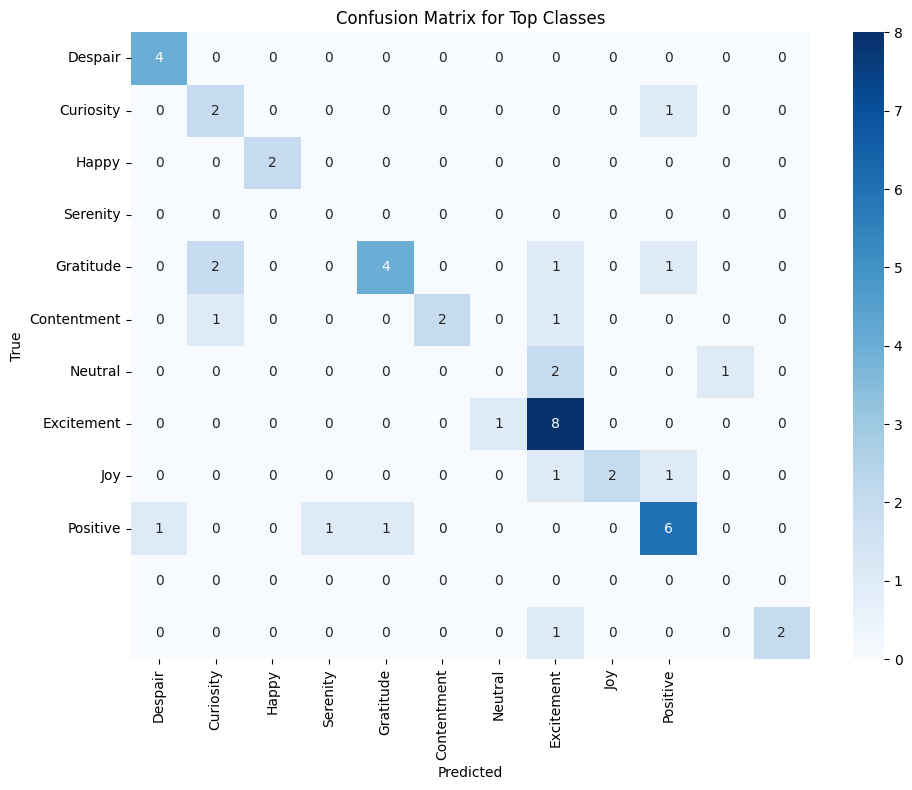

In [23]:
# Final evaluation on test set
test_loss, test_acc, all_preds, all_labels = evaluate(model, test_loader, criterion, device)
print(f"\nFinal Test Accuracy: {test_acc:.4f}")
print("Classification Report:\n", classification_report(all_labels, all_preds, zero_division=1))

# Converting numeric predictions back to original sentiment labels
predicted_classes = label_encoder.inverse_transform(all_preds)
true_classes = label_encoder.inverse_transform(all_labels)

try:
    # Get most frequent classes
    top_class_indices = np.argsort(np.bincount(all_labels))[-10:]  # Top 10 classes
    mask = np.isin(all_labels, top_class_indices)
    
    if np.sum(mask) > 0:  # If we have any samples from top classes
        cm = confusion_matrix(
            [true_classes[i] for i in range(len(true_classes)) if mask[i]],
            [predicted_classes[i] for i in range(len(predicted_classes)) if mask[i]]
        )
        
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=[label_encoder.inverse_transform([i])[0] for i in top_class_indices],
                   yticklabels=[label_encoder.inverse_transform([i])[0] for i in top_class_indices])
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title('Confusion Matrix for Top Classes')
        plt.tight_layout()
        plt.savefig('confusion_matrix.png')
        print("Confusion matrix saved to 'confusion_matrix.png'")
except ImportError:
    print("Matplotlib or seaborn not available for confusion matrix visualization")


#### Custom Test Sentences

In [ ]:
# Function to predict sentiment for new text
def predict_sentiment(text, model, vectorizer, label_encoder, device):
    processed_text = preprocess_text(text)
    text_tfidf = vectorizer.transform([processed_text]).toarray()
    text_tensor = torch.FloatTensor(text_tfidf).to(device)
    model.eval()
    with torch.no_grad():
        outputs = model(text_tensor)
        _, predicted = torch.max(outputs, 1)
    predicted_sentiment = label_encoder.inverse_transform(predicted.cpu().numpy())[0]
    
    return predicted_sentiment

# Example of prediction function usage
print("\nExample prediction function:")
print("predict_sentiment('I love this product!', model, vectorizer, label_encoder, device)")


Example prediction function:
predict_sentiment('I love this product!', model, vectorizer, label_encoder, device)
